# 3장 케라스와 텐서플로우

__감사말__

프랑소와 숄레의 [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff) 2장에 사용된 코드에 대한 설명을 담고 있으며 텐서플로우 2.6 버전 이상에서 작성되었습니다. 소스코드를 공개한 저자에게 감사드립니다.

__구글 코랩 설정__

'런타임 -> 런타임 유형 변경' 메뉴에서 GPU를 지정한다.
TensorFlow 버전을 확인하려면 아래 명령문을 실행한다.

In [1]:
import tensorflow as tf
tf.__version__

'2.8.2'

TensorFlow가 GPU를 사용하는지 여부를 확인하려면 아래 명령문을 실행한다.
아래와 같은 결과가 나오면 GPU가 제대로 지원됨을 의미한다.

```
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
```

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

**참고**

아래 코드에 대한 자세한 설명은
[케라스와 텐서플로우](https://codingalzi.github.io/dlp2/keras_and_tf.html)를 
참고한다.

## 3.5 텐서플로우 기본 사용법

### 신경망 모델 훈련 핵심 1

1. 상수 텐서와 변수 텐서
    - 상수 텐서(constant tensor): 입출력 데이터 등 변하지 않는 텐서
    - 변수 텐서(variable): 모델 가중치, 편향 등 업데이트 되는 텐서
1. 텐서 연산: 덧셈, relu, 점곱 등
1. 역전파(backpropagation): 
    - 손실함수의 그레이디언트 계산 후 모델 가중치 업데이트
    - 그레이디언트 테이프(`GradientTape`) 이용

### 텐서플로우 기본 API 활용법

In [3]:
import tensorflow as tf

#### 상수 텐서

상수 텐서는 한 번 생성되면 값을 수정할 수 없다.
딥러닝 연산에 많이 사용되는 상수 텐서는 다음과 같다.

- 상수 텐서 수동 생성

In [4]:
x = tf.constant([[1., 2.], [3., 4.]])
print(x)

tf.Tensor(
[[1. 2.]
 [3. 4.]], shape=(2, 2), dtype=float32)


- 1로만 이루어진 텐서

In [5]:
x = tf.ones(shape=(2, 1))
print(x)

tf.Tensor(
[[1.]
 [1.]], shape=(2, 1), dtype=float32)


- 0으로만 이루어진 텐서

In [6]:
x = tf.zeros(shape=(2, 1))
print(x)

tf.Tensor(
[[0.]
 [0.]], shape=(2, 1), dtype=float32)


- `normal()` 함수: 0과 1사이의 부동소수점을 정규분포를 따르도록 무작위적으로 선택
    - `mean`: 평균값
    - `stddev`: 표준편차

In [7]:
x = tf.random.normal(shape=(3, 1), mean=0., stddev=1.)
print(x)

tf.Tensor(
[[1.5681486 ]
 [0.08800379]
 [0.22982658]], shape=(3, 1), dtype=float32)


- `uniform()` 함수: 지정된 구간에서 부동소수점을 균등분포를 따르도록 무작위적으로 선택
    - `minval`: 구간 최솟값
    - `maxval`: 구간 최댓값

In [8]:
x = tf.random.uniform(shape=(3, 1), minval=0., maxval=1.)
print(x)

tf.Tensor(
[[0.9808607 ]
 [0.7159847 ]
 [0.15788722]], shape=(3, 1), dtype=float32)


한 번 생성된 상수 텐서는 수정이 불가능하다. 

```python
>>> x[0, 0] = 1.0

---------------------------------------------------------------------------
TypeError                                 Traceback (most recent call last)
<ipython-input-7-242a5d4d3c4a> in <module>
----> 1 x[0, 0] = 1.0

TypeError: 'tensorflow.python.framework.ops.EagerTensor' object does not support item assignment
```

In [9]:
x[0, 0]

<tf.Tensor: shape=(), dtype=float32, numpy=0.9808607>

In [10]:
type(x[0, 0])

tensorflow.python.framework.ops.EagerTensor

넘파이 어레이는 반면에 수정 가능하다.

In [11]:
import numpy as np

x = np.ones(shape=(2, 2))

x[0, 0] = 0.0
print(x)

[[0. 1.]
 [1. 1.]]


#### 변수 텐서

신경망 모델 훈련 도중에 가중치 텐서는 업데이트될 수 있어야 한다.
이런 텐서는 변수 텐서로 선언해야 하며, 
`Variaible` 클래스로 감싼다.

In [12]:
v = tf.Variable(initial_value=tf.random.normal(shape=(3, 1)))
print(v)

<tf.Variable 'Variable:0' shape=(3, 1) dtype=float32, numpy=
array([[ 1.1324096 ],
       [ 0.9748235 ],
       [-0.07509644]], dtype=float32)>


`Variable` 클래스의 `assign()` 메서드를 활용하여 텐서 항목 전체 또는 
일부를 수정할 수 있다.

In [13]:
v.assign(tf.ones((3, 1)))

<tf.Variable 'UnreadVariable' shape=(3, 1) dtype=float32, numpy=
array([[1.],
       [1.],
       [1.]], dtype=float32)>

__주의사항__: 모양(shape)이 동일한 텐서를 사용해야 한다.

```python
>>> v.assign(tf.ones((3, 2)))

---------------------------------------------------------------------------
ValueError                                Traceback (most recent call last)
<ipython-input-13-e381ab0c94e6> in <module>
----> 1 v.assign(tf.ones((3, 2)))

~\anaconda3\lib\site-packages\tensorflow\python\ops\resource_variable_ops.py in assign(self, value, use_locking, name, read_value)
    886         else:
    887           tensor_name = " " + str(self.name)
--> 888         raise ValueError(
    889             ("Cannot assign to variable%s due to variable shape %s and value "
    890              "shape %s are incompatible") %

ValueError: Cannot assign to variable Variable:0 due to variable shape (3, 1) and value shape (3, 2) are incompatible
```

특정 항목을 수정하려면 인덱싱과 함께 사용한다.

In [14]:
v[0, 0]

<tf.Tensor: shape=(), dtype=float32, numpy=1.0>

In [15]:
type(v[0, 0])

tensorflow.python.framework.ops.EagerTensor

상수 텐서의 경우처럼 각 항목은 `EagerTensor` 객체이지만 이번엔 항목 변환이 가능하다.
텐서플로우 내부에서 변수 텐서인 경우와 아닌 경우를 구분해서 `assign()` 메서드의 지원여부를 
판단하는 것으로 보인다.

In [16]:
v[0, 0].assign(3.)

<tf.Variable 'UnreadVariable' shape=(3, 1) dtype=float32, numpy=
array([[3.],
       [1.],
       [1.]], dtype=float32)>

`assign_add()` 메서드는 변수 텐서에 대한 덧셈 연산을 수행한다.
단, 해당 객체의 항목이 업데이트된다.

In [17]:
v.assign_add(tf.ones((3, 1)))

<tf.Variable 'UnreadVariable' shape=(3, 1) dtype=float32, numpy=
array([[4.],
       [2.],
       [2.]], dtype=float32)>

#### 텐서 연산

텐서 연산은 넘파이 어레이에 대한 연산과 거의 같다.
다음은 몇 가지 예제를 보여준다.

__참고__: 보다 다양한 텐서와 텐서 연산에 대한 자세한 설명은 [텐서플로우 가이드(TensorFlow Guide)](https://www.tensorflow.org/guide/tensor) 영어판을 참고하라.

In [18]:
import numpy as np

a = np.array([[2., 1.],
              [3., -2.]], dtype=np.float32)

In [19]:
a = tf.convert_to_tensor(a)
a += tf.ones((2, 2))
print(a)

tf.Tensor(
[[ 3.  2.]
 [ 4. -1.]], shape=(2, 2), dtype=float32)


In [20]:
b = tf.square(a)
print(b)

tf.Tensor(
[[ 9.  4.]
 [16.  1.]], shape=(2, 2), dtype=float32)


In [21]:
c = tf.sqrt(a)
print(c)

tf.Tensor(
[[1.7320508 1.4142135]
 [2.              nan]], shape=(2, 2), dtype=float32)


In [22]:
a = tf.nn.relu(a)
print(a)

tf.Tensor(
[[3. 2.]
 [4. 0.]], shape=(2, 2), dtype=float32)


In [23]:
c = tf.sqrt(a)
print(c)

tf.Tensor(
[[1.7320508 1.4142135]
 [2.        0.       ]], shape=(2, 2), dtype=float32)


In [24]:
d = b + c
print(d)

tf.Tensor(
[[10.732051   5.4142137]
 [18.         1.       ]], shape=(2, 2), dtype=float32)


`matmul()` 곱셈은 넘파이의 점곱(dot) 연산자와 유사하게 작동하며
2차원 행렬모양의 텐서의 경우 행렬 곱으로 실행된다.

In [25]:
e = tf.matmul(a, b)
print(e)

tf.Tensor(
[[59. 14.]
 [36. 16.]], shape=(2, 2), dtype=float32)


곱셈 연산자(`*`)는 항목별 곱셈으로 처리된다.

In [26]:
e *= a
print(e)

tf.Tensor(
[[177.  28.]
 [144.   0.]], shape=(2, 2), dtype=float32)


### `GradientTape` API (다시 살펴 보기)

그레이디언트 테이프는 텐서 변수에 의존하는 미분함수의 그레이디언트를 자동 계산해준다.
아래 코드는 제곱 함수의 미분을 계산한다.

$$
f(x) = x^2 \quad \Longrightarrow \quad \nabla f(x) = \frac{df(x)}{dx} = 2x
$$

In [27]:
input_var = tf.Variable(initial_value=3.)

with tf.GradientTape() as tape:
    result = tf.square(input_var)

gradient = tape.gradient(result, input_var)

print(gradient)

tf.Tensor(6.0, shape=(), dtype=float32)


그레이디언트 테이프 기능을 이용하여 신경망 모델 훈련 중에
손실 함수의 그레이디언트를 계산한다.

```python
gradient = tape.gradient(loss, weights)
```

- `loss`: `weights` 텐서 변수에 의존하는 손실 함수
- `weights`: 가중치 어레이

상수 텐서에 대해 그레이디언트 테이프를 이용하려면 `tape.watch()` 메서드로 감싸야 한다.

In [28]:
input_const = tf.constant(3.)

with tf.GradientTape() as tape:
    tape.watch(input_const)
    result = tf.square(input_const)

gradient = tape.gradient(result, input_const)

print(gradient)

tf.Tensor(6.0, shape=(), dtype=float32)


__참고__: 2차 미분도 가능하지만 여기서는 관심 대상이 아니다.

```python
time = tf.Variable(0.)

with tf.GradientTape() as outer_tape:
    with tf.GradientTape() as inner_tape:
        position =  4.9 * time ** 2
    speed = inner_tape.gradient(position, time)

acceleration = outer_tape.gradient(speed, time)
```

### 저수준 선형 분류 신경망 구현

순수 텐서플로우 API만을 이용하여 선형 분류 신경망을 구현한다.

#### 데이터셋 생성

- `np.random.multivariate_normal()`
    - 다변량 정규분포를 따르는 데이터 생성
    - 평균값과 공분산 지정 필요
- 음성 데이터셋
    - 샘플 수: 1,000
    - 평균값: `[0, 3]`
    - 공분산: `[[1, 0.5],[0.5, 1]]`
- 양성 데이터셋
    - 샘플 수: 1,000
    - 평균값: `[3, 0]`
    - 공분산: `[[1, 0.5],[0.5, 1]]`

In [29]:
num_samples_per_class = 1000

# 음성 데이터셋
negative_samples = np.random.multivariate_normal(
    mean=[0, 3], cov=[[1, 0.5],[0.5, 1]], size=num_samples_per_class)

# 양성 데이터셋
positive_samples = np.random.multivariate_normal(
    mean=[3, 0], cov=[[1, 0.5],[0.5, 1]], size=num_samples_per_class)

두 개의 `(1000, 2)` 모양의 양성, 음성 데이터셋을 하나의 `(2000, 2)` 모양의 데이터셋으로 합치면서
동시에 자료형을 `np.float32`로 지정한다. 
자료형을 지정하지 않으면 `np.float64`로 지정되어 보다 많은 메모리와 실행시간을 요구한다.

In [30]:
inputs = np.vstack((negative_samples, positive_samples)).astype(np.float32)

음성 샘플의 타깃은 0, 양성 샘플의 타깃은 1로 지정한다.

In [31]:
targets = np.vstack((np.zeros((num_samples_per_class, 1), dtype="float32"),
                     np.ones((num_samples_per_class, 1), dtype="float32")))

양성, 음성 샘플을 색깔로 구분하면 다음과 같다.

- `inputs[:, 0]`: x 좌표
- `inputs[:, 1]`: x 좌표
- `c=targets[:, 0]`: 0 또는 1에 따른 색상 지정

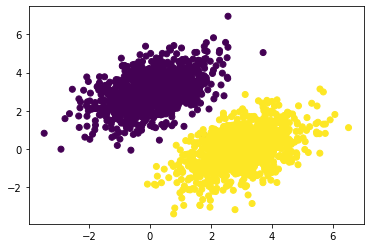

In [32]:
import matplotlib.pyplot as plt

plt.scatter(inputs[:, 0], inputs[:, 1], c=targets[:, 0])
plt.show()

#### 가중치 변수 텐서 생성

In [33]:
input_dim = 2     # 입력 샘플의 특성이 2개
output_dim = 1    # 하나의 값으로 출력

# 가중치: 무작위 초기화
W = tf.Variable(initial_value=tf.random.uniform(shape=(input_dim, output_dim)))

# 편향: 0으로 초기화
b = tf.Variable(initial_value=tf.zeros(shape=(output_dim,)))

#### 예측 모델(함수) 선언

아래 함수는 하나의 층만 사용하는 모델이 출력값을 계산하는 과정이다.

In [34]:
def model(inputs):
    return tf.matmul(inputs, W) + b

#### 손실 함수: 평균 제곱 오차(MSE)

- `tf.reduce_mean()`: 텐서에 포함된 항목들의 평균값 계산.
    넘파이의 `np.mean()`과 결과는 동일하지만 텐서플로우의 텐서를 대상으로 함.

In [35]:
def square_loss(targets, predictions):
    per_sample_losses = tf.square(targets - predictions)
    return tf.reduce_mean(per_sample_losses)

#### 훈련 단계

하나의 배치에 대해 예측값을 계산한 후에 손실 함수의 그레이디언트를 이용하여 가중치와 편향을 업데이트한다. 

In [36]:
learning_rate = 0.1

def training_step(inputs, targets):
    with tf.GradientTape() as tape:
        predictions = model(inputs)
        loss = square_loss(targets, predictions)
    grad_loss_wrt_W, grad_loss_wrt_b = tape.gradient(loss, [W, b])
    W.assign_sub(grad_loss_wrt_W * learning_rate)
    b.assign_sub(grad_loss_wrt_b * learning_rate)
    return loss

#### 배치 훈련

배치 훈련을 총 40번 반복한다.

In [37]:
for step in range(40):
    loss = training_step(inputs, targets)
    print(f"Loss at step {step}: {loss:.4f}")

Loss at step 0: 1.4593
Loss at step 1: 0.2647
Loss at step 2: 0.1266
Loss at step 3: 0.1043
Loss at step 4: 0.0961
Loss at step 5: 0.0901
Loss at step 6: 0.0847
Loss at step 7: 0.0798
Loss at step 8: 0.0752
Loss at step 9: 0.0711
Loss at step 10: 0.0673
Loss at step 11: 0.0638
Loss at step 12: 0.0606
Loss at step 13: 0.0576
Loss at step 14: 0.0549
Loss at step 15: 0.0524
Loss at step 16: 0.0502
Loss at step 17: 0.0481
Loss at step 18: 0.0461
Loss at step 19: 0.0444
Loss at step 20: 0.0427
Loss at step 21: 0.0412
Loss at step 22: 0.0399
Loss at step 23: 0.0386
Loss at step 24: 0.0375
Loss at step 25: 0.0364
Loss at step 26: 0.0354
Loss at step 27: 0.0345
Loss at step 28: 0.0337
Loss at step 29: 0.0330
Loss at step 30: 0.0323
Loss at step 31: 0.0316
Loss at step 32: 0.0310
Loss at step 33: 0.0305
Loss at step 34: 0.0300
Loss at step 35: 0.0296
Loss at step 36: 0.0291
Loss at step 37: 0.0288
Loss at step 38: 0.0284
Loss at step 39: 0.0281


훈련상태를 보면 여전히 개선의 여지가 보인다. 따라서 학습을 좀 더 시켜본다. 

In [38]:
for step in range(100):
    loss = training_step(inputs, targets)
    if step % 10 == 0:
        print(f"Loss at step {step}: {loss:.4f}")

Loss at step 0: 0.0278
Loss at step 10: 0.0259
Loss at step 20: 0.0251
Loss at step 30: 0.0247
Loss at step 40: 0.0246
Loss at step 50: 0.0245
Loss at step 60: 0.0245
Loss at step 70: 0.0245
Loss at step 80: 0.0245
Loss at step 90: 0.0245


#### 예측

In [39]:
predictions = model(inputs)

예측 결과를 확인하면 다음과 같다.
예측값이 0.5보다 클 때 양성으로 판정하는 것이 좋은데
이유는 샘플들의 레이블이 0 또는 1이기 때문이다.
모델은 훈련과정 중에 음성 샘플은 최대한 0에, 
양성 샘플은 최대한 1에 가까운 값으로 예측하여 손실값이 줄도록 
노력하며, 옵티마이저가 그렇게 유도한다.
따라서 0과 1의 중간값인 0.5가 판단 기준으로 적절하다.

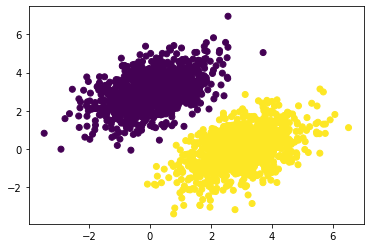

In [40]:
plt.scatter(inputs[:, 0], inputs[:, 1], c=predictions[:, 0] > 0.5)
plt.show()

결정 경계를 직선으로 그리려면 아래 식을 이용한다.

```python
y = - W[0] /  W[1] * x + (0.5 - b) / W[1]
```

이유는 위 모델의 예측값이 다음과 같이 계산되며,

```python
W[0]*x + W[1]*y + b
```

위 예측값이 0.5보다 큰지 여부에 따라 음성, 양성이 판단되기 때문이다.

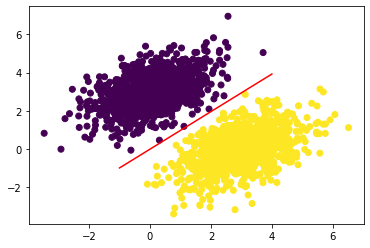

In [41]:
x = np.linspace(-1, 4, 100)
y = - W[0] /  W[1] * x + (0.5 - b) / W[1]

plt.plot(x, y, "-r")
plt.scatter(inputs[:, 0], inputs[:, 1], c=predictions[:, 0] > 0.5)

## 3.6 케라스의 핵심 API 이해

### 신경망 모델 훈련 핵심 2

1. 층(layer)과 모델: 층을 적절하게 쌓아 모델 구성
1. 손실 함수(loss function): 학습 방향을 유도하는 피드백 역할 수행
1. 옵티마이저(optimizer): 학습 방향을 정하는 기능 수행
1. 메트릭(metric): 정확도 등 모델 성능 평가 용도
1. 훈련 반복(training loop): 미니 배치 경사하강법 실행

### 층

층(layer)의 역할은 다음과 같다.

- 모델의 상태(지식)로 사용되는 가중치(weight)와 편향(bias) 저장
- 데이터 표현 변환(forward pass)

층은 사용되는 클래스에 따라 다양한 형식의 텐서를 취급한다.

- `Dense` 클래스를 사용하는 밀집층(dense layer): 
    `(샘플수, 특성수)` 모양의 2D 텐서로 제공된 데이터셋
- `LSTM` 클래스, `Conv1D` 클래스 등을 사용하는 순환층(recurrent layer): 
    `(샘플수, 타임스텝수, 특성수)` 모양의 3D 텐서로 제공된 순차 데이터셋
- `Conv2D` 클래스 등을 사용하는 층: 
    `(샘플수, 가로, 세로, 채널수)` 모양의 4D 텐서로 제공된 이미지 데이터셋
    
케라스를 활용하여 딥러닝 모델을 구성하는 것은 호환 가능한 층들을 적절하게 연결하여 층을 쌓는 것을 의미한다.

#### `Layer` 클래스

케라스에서 사용되는 모든 층 클래스는 `Layer` 클래스를 상속하며,
이를 통해 상속받는 `__call__()` 메서드가 
가중치와 편향 벡터를 생성 및 초기화하고 입력 데이터를 출력 데이터로 변환하는 일을 수행한다.

`Layer` 클래스에서 선언된 `__call__()` 메서드가 하는 일을 간략하게 나타내면 다음과 같다. 

--- 
```python
def __call__(self, inputs):
    if not self.built:
        self.build(inputs.shape)
        self.built = True
return self.call(inputs)
```
---

위 코드에 사용된 인스턴스 변수와 메서드는 다음과 같다. 

- `self.built`: 가중치와 편향 벡터가 초기화가 되어 있는지 여부 기억
- `self.build(inputs.shape)`: 입력 배치 데이터셋(`inputs`)의 모양(shape) 정보를 이용하여 
    적절한 모양의 가중치 텐서와 편향 텐서를 생성하고 초기화한다.
    - 가중치 텐서 초기화: 무작위적(`random_normal`)
    - 편향 텐서 초기화: 0 벡터(`zeros`)
- `self.call(inputs)`: 출력값 계산(forward pass)
    - 아핀 변환 및 활성화 함수 적용
    
즉, 층은 입력값이 들어오면 가장 먼저 입력값의 모양을 확인한 다음에 
가중치 텐서와 편향 텐서를 생성 및 초기화하며,
그 다음에 아핀 변환과 활성화 함수를 이용하여 출력값을 계산한다. 

층은 입렵값을 확인하면서 동시에 입력값의 모양을 확인하기 때문에 
2장에서 살펴본 MNIST 모델 사용된 `Dense` 클래스처럼 입력 데이터에 정보를 
미리 요구하지 않는다.

---
```python
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Dense(512, activation="relu"),
    layers.Dense(10, activation="softmax")
])
```
---

#### `Dense` 클래스 직접 구현하기

위 설명을 바탕으로 해서 `Dense` 클래스와 유사하게 작동하는 
`SimpleDense` 클래스를 직접 정의하려면 
`build()` 메서드와 `call()` 메서드를 아래와 같이 구현하면 된다.
두 메서드의 정의에 사용된 매개변수와 메서드는 다음과 같다.

- `units`: 출력 샘플의 특성수 지정
- `activation`: 활성화 함수 지정
- `input_shape`: 입력값(`inputs`)으로 얻은 입력 배치의 2D 모양 정보. 둘째 항목이 입력 샘플의 특성 수.
- `add_weight(모양, 초기화방법)`: 지정된 모양의 텐서 생성 및 초기화. `Layer` 클래스에서 상속.

In [42]:
from tensorflow import keras

class SimpleDense(keras.layers.Layer):

    def __init__(self, units, activation=None):
        super().__init__()
        self.units = units
        self.activation = activation

    def build(self, input_shape):
        input_dim = input_shape[-1]   # 입력 샘플의 특성 수
        self.W = self.add_weight(shape=(input_dim, self.units),
                                 initializer="random_normal")
        self.b = self.add_weight(shape=(self.units,),
                                 initializer="zeros")

    def call(self, inputs):
        y = tf.matmul(inputs, self.W) + self.b
        if self.activation is not None:
            y = self.activation(y)
        return y

`SimpleDense` 층 하나로 이루어진 모델이 작동하는 방식은 다음과 같다.

- 모델 구성: 생성자에 의해 출력 샘플의 특성수와 활성화 함수 지정.
    - 입력 데이터셋 샘플의 특성수는 지정할 필요 없음.

In [43]:
my_dense = SimpleDense(units=32, activation=tf.nn.relu)

- 입력 데이터셋 지정: 입력 샘플 하나의 특성수는 784. 샘플 수는 1000.

In [44]:
input_tensor = tf.ones(shape=(1000, 784))

출력값 생성: `__call__()` 메서드를  실행하면 다음 사항들이 연속적으로 처리된다. 

- 가중치 텐서 `W` 생성 및 초기호: `(784, 32)`
- 편향 텐서 `b` 생성 및 초기호: `(32, )`
- 생성된 가중치와 편향을 이용하여 출력값 계산(아핀 변환 및 활성화 함수 적용)

In [45]:
output_tensor = my_dense(input_tensor)

print(output_tensor.shape)

(1000, 32)


### 층에서 모델로

딥러닝 모델은 층으로 구성된 그래프라고 할 수 있다.
앞서 살펴 본 `Sequential` 모델은 층을 일렬로 쌓아 신경망을 구성하며,
층층이 쌓인 층은 아래 층에서 전달한 값을 받아 변환한 후 위 층으로 전달하는
방식으로 작동한다.
예를 들어, 아래 모델은 4개의 `SimpleDense` 층으로 구성되었다.
각 층의 역할은 앞서 설명한 `my_dense` 모델의 그것과 동일하다.
즉, 32, 64, 32, 10 개의 특성을 갖는 출력값을 계산한 후 다음 층으로 전달한다.

```python
model = keras.Sequential([
    SimpleDense(32, activation="relu"),
    SimpleDense(64, activation="relu"),
    SimpleDense(32, activation="relu"),
    SimpleDense(10, activation="softmax")
])
```

앞으로 층을 구성하는 다양한 방식을 살펴볼 것이다.
예를 들어, 아래 그림은 나중에 살펴 볼 트랜스포머(Transformer) 모델에
사용된 층들의 복잡한 관계를 보여준다.

<div align="center"><img src="https://drek4537l1klr.cloudfront.net/chollet2/v-7/Figures/transformer0001.png" style="width:500px;"></div>

그림 출처: [Deep Learning with Python(Manning MEAP)](https://www.manning.com/books/deep-learning-with-python-second-edition)

#### 가설 공간

모델의 학습과정은 층을 어떻게 구성하였는가에 전적으로 의존한다. 
앞서 살펴 보았듯이 각각의 층에서 이루어지는 일은 기본적으로 아핀 변환과 활성화 함수 적용이다. 
여러 개의 `Dense` 층을 `Sequential` 모델을 이용하여 층을 구성하면 
아핀 변환,`relu()` 등의 활성화 함수를 연속적으로 적용하여
입력 텐서를 특정 모양의 텐서로 변환한다.
반면에 다른 방식으로 구성된 모델은 다른 방식으로 텐서를 
하나의 표현에서 다른 표현으로 변환시킨다. 

이렇듯 층을 구성하는 방식에 따라 텐서들이 가질 수 있는 표현들의 공간이 정해진다.
이런 의미에서 '**망 구성방식(network topology)에 따른 표현 가설 공간(hypothesis space)**'이란 
표현을 사용한다.

#### 망 구성방식

신경망의 구성은 주어진 데이터셋과 모델의 목적에 따라 결정되며 특별한 규칙이 따로 있지는 않다.
주어진 문제를 해결하는 모델의 구성은 이론 보다는 많은 실습을 통한 경험에 의존한다.
앞으로 다양한 예제를 통해 다양한 모델을 구성하는 방식을 다룬다. 

### 모델 컴파일

모델의 구조를 정의한 후에 아래 세 가지 설정을 추가로 지정해야 한다.

- 옵티마이저(optimizer): 모델의 성능을 향상시키는 방향으로 가중치를 업데이트하는 알고리즘
- 손실함수(loss function): 훈련 중 모델의 성능 얼마 나쁜가를 측정하는 기준. 
    미분가능이어야 하며 옵티마이저가 경사하강법을 활용하여 손실함숫값을 줄이는 방향으로 작동함.
- 평가지표(metrics):: 훈련과 테스트 과정을 모니터링 할 때 사용되는 모델 평가 지표. 
    옵티마이저 또는 손실함수와 일반적으로 상관 없음.

In [46]:
model = keras.Sequential([keras.layers.Dense(1)])

In [47]:
model.compile(optimizer="rmsprop",
              loss="mean_squared_error",
              metrics=["accuracy"])

세 가지 설정에 사용된 문자열은 지정된 함수를 가리키도록 준비되어 있다.
예를 들어 아래 코드는 앞서의 컴파일과 동일한
결과가 나오도록 옵티마이저, 손실함수, 평가지표에 필요한 객체들을 직접 지정하였다.

In [48]:
model.compile(optimizer=keras.optimizers.RMSprop(),
              loss=keras.losses.MeanSquaredError(),
              metrics=[keras.metrics.BinaryAccuracy()])

앞으로 다양한 예제를 통해 옵티마이저, 손실함수, 평가지표를 적절하게 선택하는 방법을 살펴볼 것이다.

### `fit()` 메서드 작동법

모델을 훈련시키려면 `fit()` 메서드를 적절한 인자들과 함께 호출해야 한다.

- 훈련 세트: 보통 넘파이 어레이 또는 텐서플로우의 `Dataset` 객체 사용
- 에포크(`epochs`): 전체 훈련 세트를 몇 번 훈련할 지 지정
- 배치 크기(`batch_size`): 배치 경사하강법에 적용될 배치(묶음) 크기 지정

아래 코드는 앞서 넘파이 어레이로 생성한 (2000, 2) 모양의 양성, 음성 데이터셋을 대상으로 훈련한다. 

In [49]:
history = model.fit(
    inputs,
    targets,
    epochs=5,
    batch_size=128
)

Epoch 1/5
16/16 [==============================] - 0s 2ms/step - loss: 9.2690 - binary_accuracy: 0.3860
Epoch 2/5
16/16 [==============================] - 0s 2ms/step - loss: 8.9007 - binary_accuracy: 0.3795
Epoch 3/5
16/16 [==============================] - 0s 1ms/step - loss: 8.5945 - binary_accuracy: 0.3715
Epoch 4/5
16/16 [==============================] - 0s 1ms/step - loss: 8.3049 - binary_accuracy: 0.3655
Epoch 5/5
16/16 [==============================] - 0s 1ms/step - loss: 8.0233 - binary_accuracy: 0.3570


훈련이 종료되면 `fit()` 메서드는 `History` 객체를 반환하며,
`history` 속성에 훈련 과정 중에 측정된 손실값, 평가지표를 에포크 단위로 기억한다.

In [50]:
history.history

{'loss': [9.268983840942383,
  8.900737762451172,
  8.594524383544922,
  8.304852485656738,
  8.023321151733398],
 'binary_accuracy': [0.38600000739097595,
  0.37950000166893005,
  0.3714999854564667,
  0.36550000309944153,
  0.3569999933242798]}

### 검증 세트 활용

훈련된 모델이 완전히 새로운 데이터에 대해 예측을 잘하는지 여부를 판단하려면
전체 데이터셋을 훈련 세트와 **검증 세트**로 구분해야 한다.

- 훈련 세트: 모델 훈련에 사용되는 데이터셋
- 검증 세트: 훈련된 모델 평가에 사용되는 데이터셋

아래 코드는 훈련 세트와 검증 세트를 수동으로 구분하는 방법을 보여준다.

- `np.random.permutation()` 함수는 숫자들을 무작위로 섞는다.
    이를 이용하여 훈련세트의 인덱스를 무작위로 섞는다.

In [51]:
indices_permutation = np.random.permutation(len(inputs))

- 무작위로 섞인 인덱스를 이용하여 데이터셋으르 재정렬 한다.

In [52]:
shuffled_inputs = inputs[indices_permutation]
shuffled_targets = targets[indices_permutation]

- 재정렬된 데이터셋의 30%를 검증 세트로 분류한다.

In [53]:
num_validation_samples = int(0.3 * len(inputs))

val_inputs = shuffled_inputs[:num_validation_samples]
val_targets = shuffled_targets[:num_validation_samples]

- 나머지는 훈련 세트로 지정한다.

In [54]:
training_inputs = shuffled_inputs[num_validation_samples:]
training_targets = shuffled_targets[num_validation_samples:]

- 훈련 세트를 대상으로 하는 훈련과 검증 세트를 대상으로 하는 평가를 동시에 진행할 수 있다.

In [55]:
history = model.fit(
    training_inputs,
    training_targets,
    epochs=5,
    batch_size=16,
    validation_data=(val_inputs, val_targets)
)

Epoch 1/5
88/88 [==============================] - 0s 3ms/step - loss: 7.1481 - binary_accuracy: 0.3457 - val_loss: 6.6054 - val_binary_accuracy: 0.2917
Epoch 2/5
88/88 [==============================] - 0s 2ms/step - loss: 5.9011 - binary_accuracy: 0.3236 - val_loss: 5.4208 - val_binary_accuracy: 0.2783
Epoch 3/5
88/88 [==============================] - 0s 2ms/step - loss: 4.7683 - binary_accuracy: 0.3007 - val_loss: 4.3331 - val_binary_accuracy: 0.2717
Epoch 4/5
88/88 [==============================] - 0s 2ms/step - loss: 3.7769 - binary_accuracy: 0.3057 - val_loss: 3.3917 - val_binary_accuracy: 0.2767
Epoch 5/5
88/88 [==============================] - 0s 2ms/step - loss: 2.9068 - binary_accuracy: 0.3086 - val_loss: 2.5568 - val_binary_accuracy: 0.2917


`History` 객체는 훈련 세트 뿐만 아니라 검증 세트를 대상으로도 손실값과 평가지표를 기억한다.

In [56]:
history.history

{'loss': [7.148092746734619,
  5.901124477386475,
  4.768301963806152,
  3.776945114135742,
  2.9067792892456055],
 'binary_accuracy': [0.345714271068573,
  0.32357141375541687,
  0.30071428418159485,
  0.30571427941322327,
  0.3085714280605316],
 'val_loss': [6.605388164520264,
  5.420827388763428,
  4.333125591278076,
  3.3916518688201904,
  2.55679988861084],
 'val_binary_accuracy': [0.2916666567325592,
  0.2783333361148834,
  0.27166667580604553,
  0.27666667103767395,
  0.2916666567325592]}

훈련 후에 검증 세트를 이용하여 평가하려면 `evaluate()` 메서드를 이용한다.

In [57]:
loss_and_metrics = model.evaluate(val_inputs, val_targets, batch_size=128)

5/5 [==============================] - 0s 2ms/step - loss: 2.5568 - binary_accuracy: 0.2917


### 모델 활용

훈련된 모델을 활용하는 두 가지 방법이 있다.

먼저, `__call__()` 메서드를 활용한다. 즉,
데이터셋을 모델과 함께 직접 호출한다.

In [58]:
predictions = model(val_inputs)
print(predictions[:10])

tf.Tensor(
[[-1.5620422 ]
 [ 0.5021784 ]
 [-0.9082789 ]
 [-1.3354838 ]
 [ 1.0094523 ]
 [ 0.6733798 ]
 [ 1.5185957 ]
 [ 0.19927609]
 [-1.7450948 ]
 [ 0.7414676 ]], shape=(10, 1), dtype=float32)


하지만 이 방식은 데이터셋이 매우 크면 적절하지 않을 수 있다. 
따라서 `predict()` 메서드를 이용하여 배치를 활용하는 것을 추천한다.

In [59]:
predictions = model.predict(val_inputs, batch_size=128)
print(predictions[:10])

[[-1.5620422 ]
 [ 0.5021784 ]
 [-0.9082789 ]
 [-1.3354838 ]
 [ 1.0094523 ]
 [ 0.6733798 ]
 [ 1.5185957 ]
 [ 0.19927609]
 [-1.7450948 ]
 [ 0.7414676 ]]
